In [1]:
!pip install patchify

In [3]:
import rasterio
import os
import shutil
import numpy as np
from rasterio.plot import show
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff
import tensorflow as tf
import cv2

In [3]:
img1 = rasterio.open('../input/isro-satellite-data/k3_20191229071905_40634_06371168_l1g_nrg.tif')
img2 = rasterio.open('../input/isro-satellite-data/k3_20191229071905_40634_06371168_l1g_p.tif')

In [4]:
full_img_1 = img1.read()
full_img_2 = img2.read()

In [5]:
new_img2 = ((full_img_2 - full_img_2.min()) * (1/(full_img_2.max() - full_img_2.min()) * 255))
new_img2 = new_img2.reshape(new_img2.shape[1],new_img2.shape[2])

In [6]:
new_img1_b1 = ((full_img_1[0] - full_img_1[0].min()) * (1/(full_img_1[0].max() - full_img_1[0].min()) * 255))
new_img1_b2 = ((full_img_1[1] - full_img_1[1].min()) * (1/(full_img_1[1].max() - full_img_1[1].min()) * 255))
new_img1_b3 = ((full_img_1[2] - full_img_1[2].min()) * (1/(full_img_1[2].max() - full_img_1[2].min()) * 255))
new_img1_3L = np.stack([new_img1_b1/3,new_img1_b2/3,new_img1_b2/3],axis = 2)
new_img1 = np.mean(new_img1_3L, axis=2)

In [7]:
if not os.path.isdir('patches/'):
    os.mkdir('patches/')
    
else:
    shutil.rmtree('patches/')
    os.mkdir('patches/')
    
if not os.path.isdir('patches/lr_image/'):
    os.mkdir('patches/lr_image/')


large_image = new_img2

patches_img = patchify(large_image, (256, 256), step=256)

for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        single_patch_img = tf.image.resize(patches_img[i,j,:,:].reshape(256,256,1),[128,128],method= 'area')
        tiff.imwrite('patches/lr_image/' + 'image_' + '0' + '_' + str(i)+str(j)+ ".tif", tf.reshape( single_patch_img, [128,128]).numpy()) 

2023-02-22 16:13:55.288801: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-22 16:13:55.385498: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-22 16:13:55.386269: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-22 16:13:55.388274: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
if not os.path.isdir('patches/'):
    os.mkdir('patches/')
    
    
if not os.path.isdir('patches/lr_image_original/'):
    os.mkdir('patches/lr_image_original/')
    

large_image = new_img1

patches_img = patchify(large_image, (128, 128), step=128) 

for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):

        single_patch_img = patches_img[i,j,:,:]
        tiff.imwrite('patches/lr_image_original/' + 'image_' +  '0' + '_' + str(i)+str(j)+ ".tif", single_patch_img)

In [9]:
if not os.path.isdir('patches/hr_image/'):
    os.mkdir('patches/hr_image/')



large_image = new_img2

patches_img = patchify(large_image, (256, 256), step=256)

for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):

        single_patch_img = patches_img[i,j,:,:]
        tiff.imwrite('patches/hr_image/' + 'image_' + '0' + '_' + str(i)+str(j)+ ".tif", single_patch_img) 

In [10]:
import gc
del(img1)
del(img2)
del(full_img_1)
del(full_img_2)
del(new_img1_3L)
del(new_img1_b1)
del(new_img1_b2)
del(new_img1_b3)
del(new_img1)
del(new_img2)
gc.collect()

121

In [11]:
import os
import cv2
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

import tensorflow as tf
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, PReLU,BatchNormalization, Flatten,MaxPooling2D, Lambda
from tensorflow.keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm
from keras.models import load_model
from numpy.random import randint

In [12]:
import wandb
wandb.login(key='ac95228e4873096399e1436d48e0f20ee245d915')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [13]:
import wandb
wandb.init(entity="researchpapers", project = "Isro_AE GAN")

wandb: Currently logged in as: abhimnayu (researchpapers). Use `wandb login --relogin` to force relogin


In [14]:
lr_list = os.listdir('patches/lr_image_original/')
hr_list = os.listdir('patches/hr_image/')
lr_list.sort()
hr_list.sort()

lr_images = []
for img in lr_list:
    img_lr =rasterio.open("patches/lr_image_original/" + img)
    img_lr = img_lr.read()
    img_lr = img_lr.reshape((img_lr.shape[1],img_lr.shape[2],img_lr.shape[0]))
    lr_images.append(img_lr)   

   
hr_images = []
for img in hr_list:
    img_hr =rasterio.open("patches/hr_image/" + img)
    img_hr = img_hr.read()
    img_hr = img_hr.reshape((img_hr.shape[1],img_hr.shape[2],img_hr.shape[0]))
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [15]:
lr_list = os.listdir('patches/lr_image/')
hr_list = os.listdir('patches/hr_image/')
lr_list.sort()
hr_list.sort()

lr_images = []
for img in lr_list:
    img_lr =rasterio.open("patches/lr_image/" + img)
    img_lr = img_lr.read()
    img_lr = img_lr.reshape((img_lr.shape[1],img_lr.shape[2],img_lr.shape[0]))
    lr_images.append(img_lr)   

   
hr_images = []
for img in hr_list:
    img_hr =rasterio.open("patches/hr_image/" + img)
    img_hr = img_hr.read()
    img_hr = img_hr.reshape((img_hr.shape[1],img_hr.shape[2],img_hr.shape[0]))
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

In [20]:
#Define blocks to build the generator
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)
    return Model(inputs=gen_ip, outputs=op)

#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.5 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model


#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)



from tensorflow.keras.applications.vgg19 import VGG19

def build_incep(hr_shape):
    
    incep = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=incep.inputs, outputs=incep.layers[6].output)

def gray_to_rgb(images):
    return  tf.image.grayscale_to_rgb(images)

def rgb_to_gray(images):
    return  tf.image.rgb_to_grayscale(images)



#Combined model
def create_comb(gen_model, disc_model, incep, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    #lambda_layer = tf.keras.layers.Lambda(rgb_to_gray, name="lambda_layer")(gen_img)
    lambda_layer = tf.keras.layers.Lambda(gray_to_rgb, name="lambda_layer")(gen_img)
    gen_features = incep(lambda_layer)
    
    #gray_fearures = tf.keras.layers.Lambda(rgb_to_gray, name="lambda_layer")(gen_features)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 

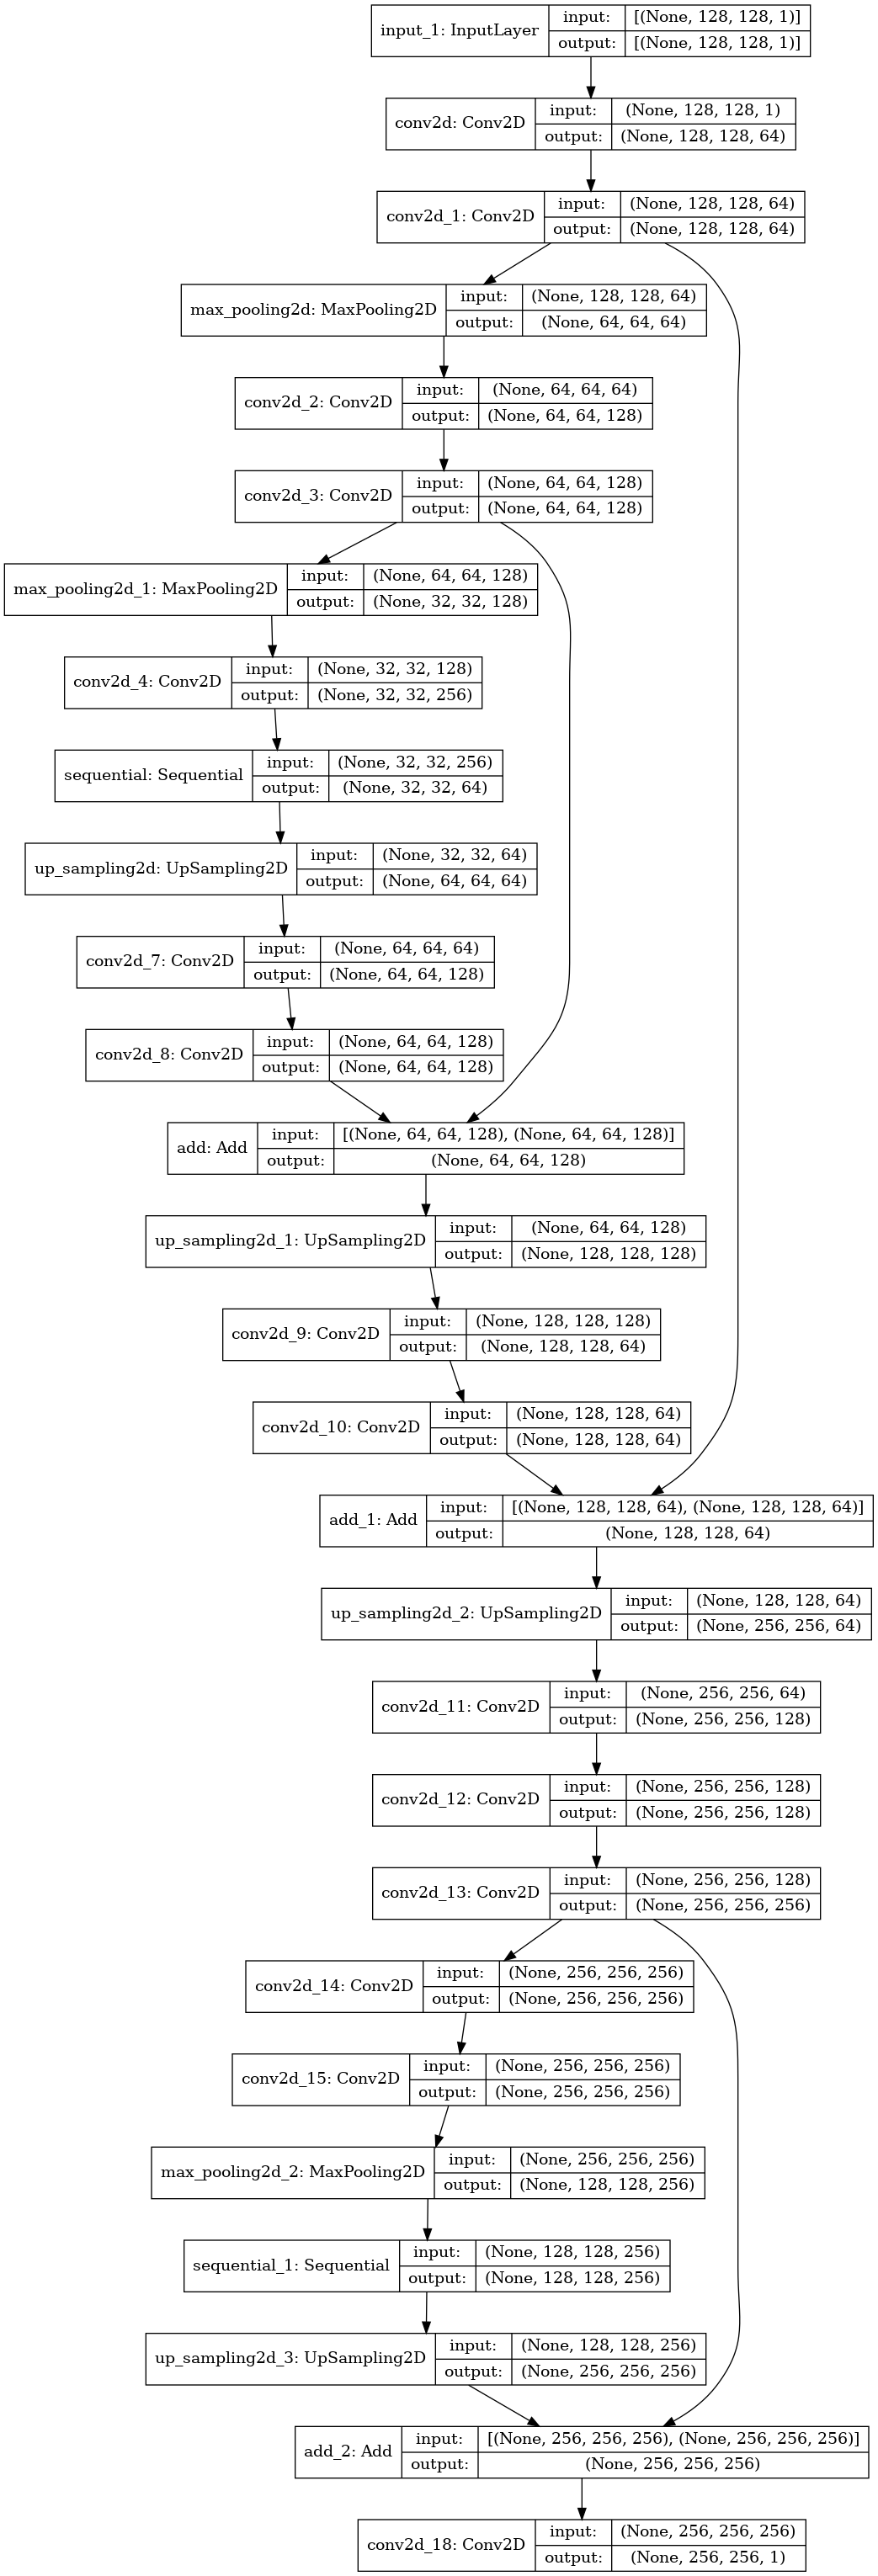

In [21]:
import os 
import re 
from scipy import ndimage, misc 
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import img_to_array


from skimage.transform import resize, rescale
import matplotlib.pyplot as plt
import numpy as np
np. random. seed(0)
import cv2 as cv2

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense ,Conv2D,MaxPooling2D ,Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
import tensorflow as tf

def wt_to_conv64(arr):
    return tf.tile(arr, [1,1,1,16])
def wt_to_conv128(arr):
    return tf.tile(arr, [1,1,1,32])

def residual_block_gen(ch=64,k_s=3,st=1):
    model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),])
    return model

input_img=Input(shape=(128,128,1))
l1=Conv2D (64,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(input_img)
l2=Conv2D (64,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l1)
l3=MaxPooling2D(padding='same')(l2)
l5=Conv2D (128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l3)
l6=Conv2D (128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l5)
l7=MaxPooling2D(padding='same')(l6)

l8=Conv2D (256,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l7)
l8=residual_block_gen()(l8)
l8=UpSampling2D()(l8)
l9=Conv2D (128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l8)
l10=Conv2D (128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l9)
l11=add([l10,l6])
l12=UpSampling2D()(l11)
l13=Conv2D (64,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l12)
l14=Conv2D (64,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l13)

l15=add([l14,l2])

l16=UpSampling2D()(l15)

l17 = Conv2D(128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l16)
l18 = Conv2D(128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l17)

#l19=UpSampling2D()(l18)

l20 = Conv2D(256,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l18)
l21 = Conv2D(256,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l20)
l22 = Conv2D(256,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l21)
l23=MaxPooling2D(padding='same')(l22)
l24 = residual_block_gen(ch=256)(l23)
l25=UpSampling2D()(l24)
l26=add([l25,l20])


decoder=Conv2D (1,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l26)

#out= tf.keras.filters
autoencoder_residual=Model(input_img,decoder)
plot_model(autoencoder_residual, to_file ='encoder.png',show_shapes=True)

In [22]:
#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape,batch_size = 1)
hr_ip = Input(shape=hr_shape,batch_size = 1)

generator = autoencoder_residual#load_model('../input/aegan-lr-2x/gen_e_15.h5', compile=True)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

incep = build_incep((256,256,3))
print(incep.summary())
incep.trainable = False

gan_model = create_comb(generator, discriminator, incep, lr_ip, hr_ip)

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [23]:
#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [24]:
epochs = 20
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    def gray_to_rgb(images):
        img = tf.convert_to_tensor(images, dtype=tf.int64) 
        return  tf.image.grayscale_to_rgb(img).numpy()

    def rgb_to_gray(images):
        img = tf.convert_to_tensor(images, dtype=tf.int64) 
        return  tf.image.rgb_to_grayscale(img).numpy()
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        #gen_imgs = rgb_to_gray(fake_imgs)
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = incep.predict(gray_to_rgb(hr_imgs))
        
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    wandb.log({"g_loss": g_loss, "epoch": e+1,
           'Discriminator Loss(False-False)': d_loss[0],
           'Discriminator Loss(True-True)': d_loss[1]})
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 5 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")

  0%|          | 0/3528 [00:00<?, ?it/s]2023-02-22 16:16:13.295356: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-22 16:16:14.426878: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
100%|██████████| 3528/3528 [13:59<00:00,  4.20it/s]


epoch: 1 g_loss: 176.8292979004702 d_loss: [2.34621078 0.89512472]


100%|██████████| 3528/3528 [13:43<00:00,  4.29it/s]


epoch: 2 g_loss: 137.19427893545623 d_loss: [1.24390487 0.97137188]


100%|██████████| 3528/3528 [13:46<00:00,  4.27it/s]


epoch: 3 g_loss: 130.9246438095629 d_loss: [1.1781553  0.97661565]


100%|██████████| 3528/3528 [13:51<00:00,  4.24it/s]


epoch: 4 g_loss: 126.95645137060257 d_loss: [0.94132987 0.98497732]


100%|██████████| 3528/3528 [13:52<00:00,  4.24it/s]
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


epoch: 5 g_loss: 124.41020918108708 d_loss: [0.66402429 0.99121315]


100%|██████████| 3528/3528 [13:50<00:00,  4.25it/s]


epoch: 6 g_loss: 122.44859927906201 d_loss: [0.58489655 0.99348073]


100%|██████████| 3528/3528 [13:53<00:00,  4.23it/s]


epoch: 7 g_loss: 121.0567434996434 d_loss: [0.42196342 0.99362245]


100%|██████████| 3528/3528 [13:51<00:00,  4.24it/s]


epoch: 8 g_loss: 119.96979825026324 d_loss: [0.4082969  0.99362245]


100%|██████████| 3528/3528 [13:51<00:00,  4.24it/s]


epoch: 9 g_loss: 119.46930608511512 d_loss: [0.28646556 0.99645692]


100%|██████████| 3528/3528 [13:55<00:00,  4.22it/s]


epoch: 10 g_loss: 118.44594363560752 d_loss: [7.03831058e-10 1.00000000e+00]


100%|██████████| 3528/3528 [13:55<00:00,  4.22it/s]


epoch: 11 g_loss: 117.96823333558582 d_loss: [0.51304733 0.99603175]


100%|██████████| 3528/3528 [13:53<00:00,  4.23it/s]


epoch: 12 g_loss: 117.28825707662673 d_loss: [0.27125403 0.99645692]


100%|██████████| 3528/3528 [13:43<00:00,  4.28it/s]


epoch: 13 g_loss: 116.80915800622262 d_loss: [0.21370763 0.99674036]


100%|██████████| 3528/3528 [13:34<00:00,  4.33it/s]


epoch: 14 g_loss: 116.33000875654675 d_loss: [1.10978569e-13 1.00000000e+00]


100%|██████████| 3528/3528 [13:34<00:00,  4.33it/s]


epoch: 15 g_loss: 116.31871401101283 d_loss: [0.16169182 0.99716553]


 27%|██▋       | 965/3528 [03:41<09:33,  4.47it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3528/3528 [13:32<00:00,  4.34it/s]


epoch: 16 g_loss: 115.71338780937282 d_loss: [0.25680939 0.99532313]


100%|██████████| 3528/3528 [13:33<00:00,  4.34it/s]


epoch: 17 g_loss: 115.21154676813657 d_loss: [2.74442863e-34 1.00000000e+00]


100%|██████████| 3528/3528 [13:36<00:00,  4.32it/s]


epoch: 18 g_loss: 114.8725734881533 d_loss: [2.74442863e-34 1.00000000e+00]


100%|██████████| 3528/3528 [13:36<00:00,  4.32it/s]


epoch: 19 g_loss: 114.87174223880379 d_loss: [2.74442863e-34 1.00000000e+00]


 90%|█████████ | 3186/3528 [12:08<01:17,  4.44it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3528/3528 [13:31<00:00,  4.35it/s]


epoch: 22 g_loss: 114.13256935413733 d_loss: [2.74442863e-34 1.00000000e+00]


 12%|█▏        | 433/3528 [01:39<12:24,  4.16it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3528/3528 [13:29<00:00,  4.36it/s]


epoch: 23 g_loss: 113.54195787576862 d_loss: [2.74442863e-34 1.00000000e+00]


100%|██████████| 3528/3528 [13:25<00:00,  4.38it/s]


epoch: 24 g_loss: 113.47580185606907 d_loss: [2.74442863e-34 1.00000000e+00]


 21%|██        | 731/3528 [02:54<10:45,  4.34it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3528/3528 [13:51<00:00,  4.24it/s]


epoch: 25 g_loss: 113.2584097239436 d_loss: [2.74442863e-34 1.00000000e+00]


 50%|████▉     | 1749/3528 [06:49<06:39,  4.45it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3528/3528 [13:45<00:00,  4.27it/s]


epoch: 26 g_loss: 113.1392720172735 d_loss: [2.74442863e-34 1.00000000e+00]


 73%|███████▎  | 2586/3528 [09:54<03:37,  4.34it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 91%|█████████ | 3212/3528 [12:26<01:09,  4.54it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3528/3528 [13:30<00:00,  4.35it/s]


epoch: 29 g_loss: 112.8194648403159 d_loss: [2.74442863e-34 1.00000000e+00]


 20%|██        | 707/3528 [02:42<10:28,  4.49it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3528/3528 [13:43<00:00,  4.28it/s]


epoch: 30 g_loss: 112.16381224699302 d_loss: [2.74442863e-34 1.00000000e+00]


 48%|████▊     | 1685/3528 [06:31<07:54,  3.88it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3528/3528 [13:36<00:00,  4.32it/s]


epoch: 31 g_loss: 112.22028211887732 d_loss: [2.74442863e-34 1.00000000e+00]


100%|██████████| 3528/3528 [13:30<00:00,  4.35it/s]


epoch: 32 g_loss: 112.0242709918898 d_loss: [2.74442863e-34 1.00000000e+00]


100%|██████████| 3528/3528 [13:29<00:00,  4.36it/s]


epoch: 33 g_loss: 112.1305649091327 d_loss: [2.74442863e-34 1.00000000e+00]


100%|██████████| 3528/3528 [13:38<00:00,  4.31it/s]


epoch: 34 g_loss: 111.6031341595985 d_loss: [2.74442863e-34 1.00000000e+00]


100%|██████████| 3528/3528 [13:30<00:00,  4.35it/s]


epoch: 35 g_loss: 111.40242197400048 d_loss: [2.74442863e-34 1.00000000e+00]


100%|██████████| 3528/3528 [13:29<00:00,  4.36it/s]


epoch: 36 g_loss: 111.39123620576058 d_loss: [2.74442863e-34 1.00000000e+00]


 22%|██▏       | 782/3528 [03:01<10:10,  4.50it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3528/3528 [13:26<00:00,  4.37it/s]


epoch: 37 g_loss: 111.275537331899 d_loss: [1.68836285e-27 1.00000000e+00]


 39%|███▉      | 1392/3528 [05:17<08:03,  4.42it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3528/3528 [13:29<00:00,  4.36it/s]


epoch: 38 g_loss: 110.83515909848029 d_loss: [2.74442863e-34 1.00000000e+00]


100%|██████████| 3528/3528 [13:26<00:00,  4.37it/s]


epoch: 39 g_loss: 110.985838390532 d_loss: [2.74442863e-34 1.00000000e+00]


100%|██████████| 3528/3528 [13:27<00:00,  4.37it/s]


epoch: 40 g_loss: 110.687912879347 d_loss: [2.74442863e-34 1.00000000e+00]


 93%|█████████▎| 3293/3528 [12:44<00:52,  4.44it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3528/3528 [13:28<00:00,  4.36it/s]


epoch: 43 g_loss: 110.45294631581729 d_loss: [2.74442863e-34 1.00000000e+00]


100%|██████████| 3528/3528 [13:26<00:00,  4.38it/s]


epoch: 44 g_loss: 110.10894370889989 d_loss: [2.74442863e-34 1.00000000e+00]


100%|██████████| 3528/3528 [13:29<00:00,  4.36it/s]


epoch: 45 g_loss: 110.16317419778733 d_loss: [2.74442863e-34 1.00000000e+00]


100%|██████████| 3528/3528 [13:35<00:00,  4.33it/s]


epoch: 46 g_loss: 109.93881753891233 d_loss: [2.74442863e-34 1.00000000e+00]


100%|██████████| 3528/3528 [13:40<00:00,  4.30it/s]


epoch: 47 g_loss: 109.95139707080902 d_loss: [2.74442863e-34 1.00000000e+00]


 58%|█████▊    | 2061/3528 [07:57<05:31,  4.43it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3528/3528 [13:36<00:00,  4.32it/s]


epoch: 48 g_loss: 109.81426876959077 d_loss: [2.74442863e-34 1.00000000e+00]


 76%|███████▌  | 2688/3528 [10:16<03:03,  4.58it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 3528/3528 [13:29<00:00,  4.36it/s]

epoch: 50 g_loss: 109.61848056667786 d_loss: [2.74442873e-34 1.00000000e+00]


Text(0, 0.5, 'Values')

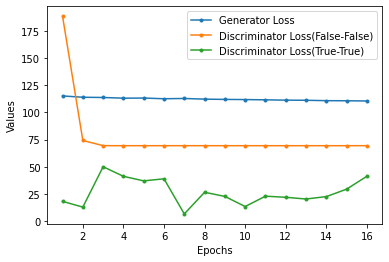

In [25]:
gen_loss = [115.20941616780634,113.976418678993,113.76942759684695,113.12779033427336,113.25671683958058,112.60468086039398,112.86494744986364,112.24326507412657,111.99943249349961, 111.85351464105031,111.61091884734138,111.30855091683178,111.20278746308654,110.8413352393239,110.74683088185836,110.53594053683638]
dis_loss = [[1.88655743, 0.18041383],[0.74163327, 0.12698413],[0.69359824, 0.49957483],[0.69324515, 0.41099773],[0.69332292, 0.36904762],[0.69328549, 0.38818027],[0.69328383, 0.06448413],[0.69329057, 0.26403061],[0.69325749, 0.22576531],[0.69325227, 0.13265306],[0.69325271, 0.22803288],[0.69324588, 0.21768707],[0.69325097, 0.20181406],[0.69324588, 0.22420635],[0.69326526, 0.29265873],[0.69338483, 0.41170635]]
gen_loss = np.array(gen_loss)
dis_loss = np.array(dis_loss)
epochs = np.array([i for i in range(1,17)])
plt.plot(epochs, gen_loss,marker = '.',label = 'Generator Loss')
plt.plot(epochs,dis_loss[:,0]*100,marker = '.',label = 'Discriminator Loss(False-False)')
plt.plot(epochs,dis_loss[:,1]*100,marker = '.',label = 'Discriminator Loss(True-True)')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Values')

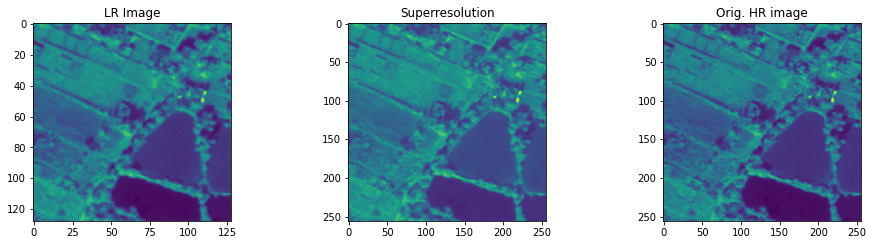

In [26]:
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

#generator = load_model('../input/ae-gan-2x/gen_e_30.h5', compile=False)#autoencoder_residual

def rgb_to_gray(images):
    return  tf.image.rgb_to_grayscale(images).numpy()

[X1, X2] = [lr_test, hr_test]
# select random example
ix = np.array([2])
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)

cv2.imwrite('SR_IMG_3.tif', gen_image.reshape(256,256,1))

cv2.imwrite('LR_IMG_3.tif', src_image.reshape(128,128,1))

cv2.imwrite('HR_IMG_3.tif', tar_image.reshape(256,256,1))

# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

In [27]:
#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(lr_images.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_lr_batches.append(lr_images[start_idx:end_idx])

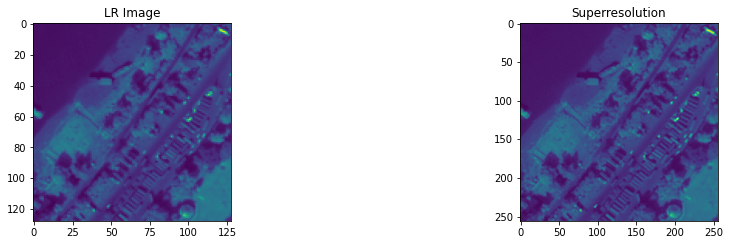

In [28]:
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

generator = load_model('./gen_e_15.h5', compile=False)#autoencoder_residual

src_image = lr_images[2].reshape(1,128,128,1)

# generate image from source
gen_image = generator.predict(src_image)

cv2.imwrite('SR_IMG_3.tif', gen_image.reshape(256,256,1))

cv2.imwrite('LR_IMG_3.tif', src_image.reshape(128,128,1))


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(221)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(222)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])


plt.show()